In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 185)
# Matt Burke found this, shows all dtypes when run

In [3]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

In [4]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [ ]:
train.dtypes

In [ ]:
train.isna().sum()

In [ ]:
# Counting NAs, a few are there because house doesn't have something (pool/basement) or are 0
for col in train:
    if train[col].isna().sum() > 0:
        print(f'{col} -- {train[col].isna().sum()}')

In [ ]:
train.shape

In [ ]:
train.columns

In [5]:
new_col_names = {}
for col in train:
    new_col_names[col] = col.lower().replace(' ', '_')
train.rename(columns=new_col_names, inplace=True)
train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [6]:
new_col_names = {}
for col in test:
    new_col_names[col] = col.lower().replace(' ', '_')
test.rename(columns=new_col_names, inplace=True)
test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [48]:
def redo_ords(df, series):
    new_ords = {
        'Ex' : 5,
        'Gd' : 4,
        'TA' : 3,
        'Fa' : 2,
        'Po' : 1,
        'NA' : 0,
        np.nan : 0
    }
    return df[series].replace(new_ords)

In [8]:
# combining outside-ish areas (decks/porches)
def fin_outside_sf(df):
    df['finished_outside'] = df['wood_deck_sf'] + df['open_porch_sf'] + df['enclosed_porch'] + df['3ssn_porch'] + df['screen_porch'] + df['pool_area']
    

In [9]:
# Counting Half Baths as half a bathroom and adding it to the rest of them
def combine_baths(df):
    df['baths'] = df['bsmt_full_bath'] + df['full_bath'] + df['bsmt_half_bath'] / 2 + df['half_bath'] / 2

In [10]:
train['total_sf'] = (train['total_bsmt_sf'] + train['gr_liv_area'])
train.dropna(subset=['total_sf'], inplace=True)
test['total_sf'] = (test['total_bsmt_sf'] + test['gr_liv_area'])


In [11]:


features = ['total_sf', 'bedroom_abvgr']
X = train[features]
y = train['saleprice']
lr = LinearRegression()
lr.fit(X, y)
predictions = lr.predict(test[features])

bad_pred = pd.DataFrame()
bad_pred['Id'] = test['id']
bad_pred['SalePrice'] = predictions
bad_pred.head()

bad_pred.to_csv('./datasets/quick_submit.csv', index=False)

In [12]:
ords_to_conv = ['exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'bsmtfin_type_2',
               'heating_qc', 'kitchen_qual']


In [13]:
# To dummy
train = pd.get_dummies(train, columns = ['ms_subclass', 'neighborhood', 
                                         'bldg_type', 'house_style', 'sale_type'],
                       drop_first=True)
test = pd.get_dummies(test, columns = ['ms_subclass', 'neighborhood', 
                                         'bldg_type', 'house_style', 'sale_type'],
                       drop_first=True)


In [14]:
train.shape

(2050, 138)

In [15]:
test.shape

(878, 135)

In [16]:
# Convert to ints from ordinal names
# exter_qual, exter_cond, bsmt_qual, bsmt_cond, bsmtfins, heating_qc, kitchen_qual
for ser in ords_to_conv:
    train[ser] = redo_ords(train, ser)
    
# other conversions -- some to 1/0s
train['lot_shape_reg'] = np.where(train['lot_shape'] == 'Reg', 1, 0)
# lot_shape -regular = 1 / irreg = 0

# central air - 1 = Y
train['central_air'] = np.where(train['central_air'] == 'Y', 1, 0)

# combining all bathrooms
combine_baths(train)

# functional
funct_rating_scale = {
    'Typ' : 7,
    'Min1' : 6,
    'Min2' : 5,
    'Mod' : 4,
    'Maj1' : 3,
    'Maj2' : 2,
    'Sev' : 1,
    'Sal' : 0
}
train.replace(funct_rating_scale, inplace=True)
# adding outside areas
fin_outside_sf(train)

# Pool to 1/0
train['pool'] = np.where(train['pool_qc'] == 'NA', 0, 1)

In [17]:
# converting ordinals to numbers
for ser in ords_to_conv:
    test[ser] = redo_ords(test, ser)

# other conversions -- some to 1/0s
test['lot_shape_reg'] = np.where(test['lot_shape'] == 'Reg', 1, 0)
# lot_shape -regular = 1 / irreg = 0

# central air - 1 = Y
test['central_air'] = np.where(test['central_air'] == 'Y', 1, 0)

# combining all bathrooms
combine_baths(test)

# functional
funct_rating_scale = {
    'Typ' : 7,
    'Min1' : 6,
    'Min2' : 5,
    'Mod' : 4,
    'Maj1' : 3,
    'Maj2' : 2,
    'Sev' : 1,
    'Sal' : 0
}
test.replace(funct_rating_scale, inplace=True)
# adding outside areas
fin_outside_sf(test)

# Pool to 1/0
test['pool'] = np.where(test['pool_qc'] == 'NA', 0, 1)

In [52]:
# Pulling the feature that seem important

feats_to_check = [
    'id',
    'lot_area',
    'overall_qual',
    'overall_cond',
    'year_remod/add',
    'exter_qual',
    'exter_cond',
    'bsmt_qual',
    'bsmt_cond',
    'total_bsmt_sf',
    'heating_qc',
    'central_air',
    'gr_liv_area',
    'bedroom_abvgr',
    'kitchen_abvgr',
    'kitchen_qual',
    'totrms_abvgrd',
    'functional',
    'fireplaces',
    'garage_area',
    'misc_val',
    'total_sf',
    'finished_outside',
    'lot_shape_reg',
    'baths',
    'pool',
    'mo_sold',
    'yr_sold',
    'bldg_type_2fmCon',
    'bldg_type_Duplex',
    'bldg_type_Twnhs',
    'bldg_type_TwnhsE',
    'neighborhood_Blueste',
    'neighborhood_BrDale',
    'neighborhood_BrkSide',
    'neighborhood_ClearCr',
    'neighborhood_CollgCr',
    'neighborhood_Crawfor',
    'neighborhood_Edwards',
    'neighborhood_Gilbert',
    'neighborhood_Greens',
    'neighborhood_IDOTRR',
    'neighborhood_MeadowV',
    'neighborhood_Mitchel',
    'neighborhood_NAmes',
    'neighborhood_NPkVill',
    'neighborhood_NWAmes',
    'neighborhood_NoRidge',
    'neighborhood_NridgHt',
    'neighborhood_OldTown',
    'neighborhood_SWISU',
    'neighborhood_Sawyer',
    'neighborhood_SawyerW',
    'neighborhood_Somerst',
    'neighborhood_StoneBr',
    'neighborhood_Timber',
    'neighborhood_Veenker',
    'sale_type_CWD',
    'sale_type_Con',
    'sale_type_ConLD',
    'sale_type_ConLI',
    'sale_type_ConLw',
    'sale_type_New',
    'sale_type_Oth',
    'sale_type_WD ',
    'ms_subclass_30',
    'ms_subclass_40',
    'ms_subclass_45',
    'ms_subclass_50',
    'ms_subclass_60',
    'ms_subclass_70',
    'ms_subclass_75',
    'ms_subclass_80',
    'ms_subclass_85',
    'ms_subclass_90',
    'ms_subclass_120',
    'ms_subclass_160',
    'ms_subclass_180',
    'ms_subclass_190',
    'house_style_1.5Unf',
    'house_style_1Story',
    'house_style_2.5Fin',
    'house_style_2.5Unf',
    'house_style_2Story',
    'house_style_SFoyer',
    'house_style_SLvl',
    
]

In [53]:
# Removing a few rows from the training set because it's not in the test set.
# GrnHill has 2, Landmrk has 1, ms_sub_class_150 has 1

train.drop(train[train['neighborhood_GrnHill'] == 1].index, inplace=True)
train.drop(train[train['neighborhood_Landmrk'] == 1].index, inplace=True)
train.drop(train[train['ms_subclass_150'] == 1].index, inplace=True)

In [54]:
train_clean = pd.DataFrame()
train_clean['saleprice'] = train['saleprice']
for ser in feats_to_check:
    train_clean[ser] = train[ser]
train_clean.to_csv('./datasets/train_clean.csv')

In [55]:
test_clean = pd.DataFrame()
for ser in feats_to_check:
    test_clean[ser] = test[ser]
test_clean.to_csv('./datasets/test_clean.csv')

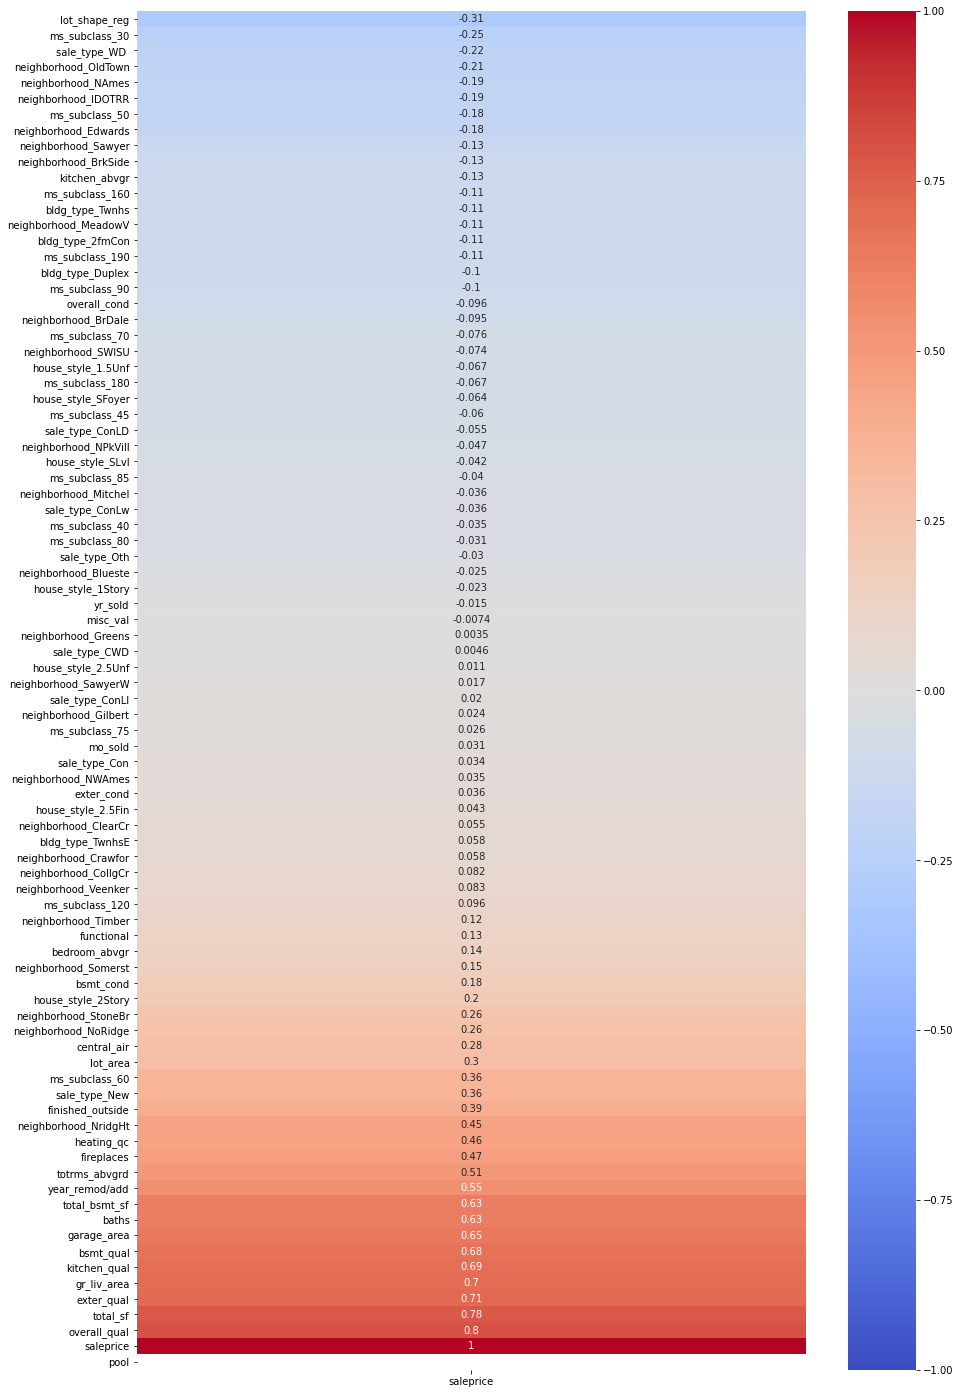

In [47]:
#CAN USE HEATMAP LIKE THIS TO MAKE IT USABLE FOR SO MANY VALUES
# sns.heatmap(df[['price']],...) Can sort it as well
# can use vmin=-1 and vmax=1 to bound it
plt.figure(figsize=(15,25))
sns.heatmap(train_clean.corr()[['saleprice']].sort_values('saleprice'),
           cmap='coolwarm',
           vmin=-1, vmax=1,
           annot=True)

In [60]:
test['mo_sold'].sort_values(ascending=False)

748    12
509    12
249    12
275    12
787    12
       ..
92      1
501     1
480     1
473     1
518     1
Name: mo_sold, Length: 878, dtype: int64

In [61]:
test['yr_sold'].sort_values(ascending=False)


607    2010
743    2010
147    2010
515    2010
752    2010
       ... 
367    2006
369    2006
373    2006
386    2006
0      2006
Name: yr_sold, Length: 878, dtype: int64

In [65]:
train['condition_2'].value_counts(normalize=True)

Norm      0.987292
Feedr     0.005376
Artery    0.002444
PosN      0.001466
PosA      0.001466
RRNn      0.000978
RRAn      0.000489
RRAe      0.000489
Name: condition_2, dtype: float64

In [64]:
train['condition_1'].value_counts(normalize=True)

Norm      0.861681
Feedr     0.052786
Artery    0.034213
RRAn      0.017595
PosN      0.013196
RRAe      0.010264
PosA      0.005865
RRNn      0.002933
RRNe      0.001466
Name: condition_1, dtype: float64

In [66]:
train['saleprice'].mean()

181461.36754643207